Hey everyone! This notebook presents a sign language digit classifier, based on lessons 1 and 2 of fast.ai Practical Deep Learning for Coders v5.

NB: Images in the dataset used to train the classifier have white backgrounds, and no objects other than hands in the images. This may cause issues for this model in production as the model may struggle to classify images with different backgrounds or other objects in the frame. A data augmentation step to fix/reduce this problem might be to make the white background transparent and merge with a variety of different backgrounds: https://stackoverflow.com/questions/765736/how-to-use-pil-to-make-all-white-pixels-transparent. N

##Set up fast.ai, Kaggle link and gradio

In [ ]:
# Install fast.ai

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

NameError: name '_C' is not defined

In [ ]:
# Import fast.ai widgets (used for original notebook app)

from fastbook import *
from fastai.vision.widgets import *

In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Install kaggle

!pip install kaggle

In [ ]:
# Install gradio

!pip install gradio
import gradio as gr

     |████████████████████████████████| 2.9 MB 5.3 MB/s 
     |████████████████████████████████| 212 kB 48.2 MB/s 
     |████████████████████████████████| 54 kB 3.7 MB/s 
     |████████████████████████████████| 2.0 MB 23.9 MB/s 
     |████████████████████████████████| 253 kB 52.2 MB/s 
     |████████████████████████████████| 53 kB 1.5 MB/s 
     |████████████████████████████████| 84 kB 3.1 MB/s 
     |████████████████████████████████| 1.1 MB 44.9 MB/s 
     |████████████████████████████████| 271 kB 50.5 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 144 kB 50.8 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 10.9 MB 48.4 MB/s 
     |████████████████████████████████| 79 kB 7.0 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 856 kB 51.9 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
     |████████████████████████

/usr/local/lib/python3.7/dist-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [ ]:
# Change working directory

%cd /content/gdrive/MyDrive/09_Colab_Notebooks/fast.ai/

/content/gdrive/MyDrive/09_Colab_Notebooks/fast.ai


In [ ]:
# Configure path to kaggle.json

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/09_Colab_Notebooks/fast.ai/"

##Gather data

In [ ]:
# Get dataset from Kaggle

!kaggle datasets download -d javaidahmadwani/sign-language-digits-dataset --unzip

sign-language-digits-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


100 100


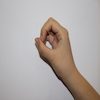

In [ ]:
# Check sample image file

dest='/content/gdrive/MyDrive/09_Colab_Notebooks/fast.ai/Sign-Language-Digits-Datase/train/A0/IMG_1118.JPG'
im = Image.open(dest)
width, height = im.size
print(height,width)
im

In [ ]:
# Define path to image dataset

path = Path('/content/gdrive/MyDrive/09_Colab_Notebooks/fast.ai/Sign-Language-Digits-Datase/train')

In [ ]:
# Check number and type of files in image dataset

fns = get_image_files(path)
fns

(#2011) [Path('/content/gdrive/MyDrive/09_Colab_Notebooks/fast.ai/Sign-Language-Digits-Datase/train/A0/IMG_1189.JPG'),Path('/content/gdrive/MyDrive/09_Colab_Notebooks/fast.ai/Sign-Language-Digits-Datase/train/A0/IMG_1301.JPG'),Path('/content/gdrive/MyDrive/09_Colab_Notebooks/fast.ai/Sign-Language-Digits-Datase/train/A0/IMG_4099.JPG'),Path('/content/gdrive/MyDrive/09_Colab_Notebooks/fast.ai/Sign-Language-Digits-Datase/train/A0/IMG_4129.JPG'),Path('/content/gdrive/MyDrive/09_Colab_Notebooks/fast.ai/Sign-Language-Digits-Datase/train/A0/IMG_4243.JPG'),Path('/content/gdrive/MyDrive/09_Colab_Notebooks/fast.ai/Sign-Language-Digits-Datase/train/A0/IMG_4266.JPG'),Path('/content/gdrive/MyDrive/09_Colab_Notebooks/fast.ai/Sign-Language-Digits-Datase/train/A0/IMG_4348.JPG'),Path('/content/gdrive/MyDrive/09_Colab_Notebooks/fast.ai/Sign-Language-Digits-Datase/train/A0/IMG_4413.JPG'),Path('/content/gdrive/MyDrive/09_Colab_Notebooks/fast.ai/Sign-Language-Digits-Datase/train/A0/IMG_4446.JPG'),Path('/con

In [ ]:
# Check whether any images corrupted

failed = verify_images(fns)
failed

(#0) []

In [ ]:
# Unlink corrupted images

failed.map(Path.unlink)

(#0) []

##DataBlocks and Data Augmentation

In [ ]:
# Define Digits DataBlock

digits = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(100))

In [ ]:
# Identify the path where the images can be found

dls = digits.dataloaders(path)

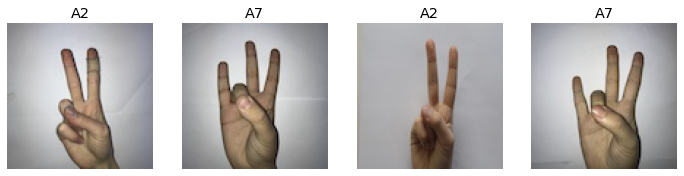

In [ ]:
# Check out a batch of data

dls.valid.show_batch(max_n=4, nrows=1)

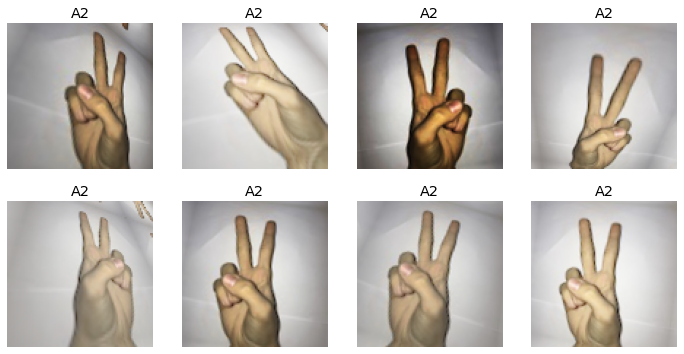

In [ ]:
# Create some random variations of our input data through data argumentation -> the `aug_transforms` function

digits = digits.new(item_tfms=Resize(100), batch_tfms=aug_transforms(mult=2))
dls = digits.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
# Create some random variations of our input data using RandomResizedCrop and aug_transforms

digits = digits.new(
    item_tfms=RandomResizedCrop(200, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = digits.dataloaders(path)

##Train the model

In [ ]:
# Train using vision_learner

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.568596,0.736919,0.248756,00:12


epoch,train_loss,valid_loss,error_rate,time
0,1.121387,0.435576,0.154229,00:12
1,0.824129,0.181515,0.059701,00:12
2,0.585747,0.213408,0.064677,00:12
3,0.420259,0.099216,0.029851,00:12
4,0.313107,0.085301,0.022388,00:12
5,0.257507,0.082711,0.022388,00:12


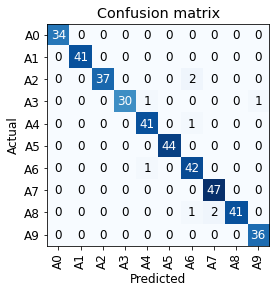

In [ ]:
# Check the results with a confusion matrix

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

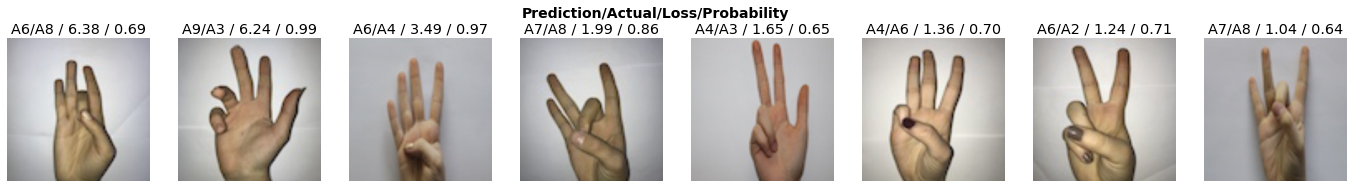

In [ ]:
# Plot the top losses

interp.plot_top_losses(8, nrows=1)

In [ ]:
# Run image classifier cleaner to clean any miscategorised
# training data. NB: ImageClassifierCleaner runs the model
# which is why you pass it (learn)

cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
# None to remove, but run this cell anyway for completeness

for id in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

##Turn Model into App

In [ ]:
# Save a file called "export.pkl"

learn.export()

In [ ]:
# Confirm the save worked

path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
# Create an inference learner by passing in
# the file name you saved (the same learner you
# used while training)

learn_inf = load_learner(path/'export.pkl')

In [ ]:
# Check an image of a 5 from the valid set

% time learn_inf.predict('/content/gdrive/MyDrive/09_Colab_Notebooks/fast.ai/Sign-Language-Digits-Datase/valid/A5/IMG_5178.JPG')

CPU times: user 128 ms, sys: 13.6 ms, total: 142 ms
Wall time: 832 ms


('A5',
 TensorBase(5),
 TensorBase([7.6756e-10, 3.3170e-11, 3.1026e-13, 2.8747e-07, 1.0797e-07, 1.0000e+00, 5.3464e-10, 6.4513e-11, 3.4962e-09, 8.7977e-07]))

In [ ]:
# Access the DataLoaders to understand the index of the vocab

learn_inf.dls.vocab

['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9']

##Build the web app

###Create a web app  with HF + Gradio (attempt 2)

In [ ]:
# Create image classifier function

categories = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

def classify_image(img):
  pred,idx,probs = learn.predict(img)
  return dict(zip(categories, map(float,probs)))

In [ ]:
# Check function

classify_image('/content/gdrive/MyDrive/09_Colab_Notebooks/fast.ai/Sign-Language-Digits-Datase/valid/A5/IMG_5178.JPG')

{'0': 7.675546309648951e-10,
 '1': 3.31695053368275e-11,
 '2': 3.102497913524266e-13,
 '3': 2.8747214741997595e-07,
 '4': 1.0796904348353564e-07,
 '5': 0.9999986886978149,
 '6': 5.346144082984949e-10,
 '7': 6.451188194755986e-11,
 '8': 3.496165579264243e-09,
 '9': 8.797545092420478e-07}

In [ ]:
# Build and deploy app via Gradio

image = gr.inputs.Image(shape=(100,100))
label = gr.outputs.Label()
title = "Sign Language Digit Classifier"
description = "A sign language digit classifier trained on a Kaggle dataset with fastai. Created as a demo for fast.ai Part 1 v5 (2022)."
examples = ['7.jpg','8.jpg','OK.jpg']

gr.Interface(fn=classify_image,inputs=gr.inputs.Image(shape=(100, 100)),outputs=gr.outputs.Label(num_top_classes=3),title=title,description=description,examples=examples).launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://20978.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7fc1e7c97c90>,
 'http://127.0.0.1:7860/',
 'https://20978.gradio.app')